In [1]:
import glob
import clip
import os
from torch import nn
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
# from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import requests

from clip_prefix_captioning import MLP, ClipCaptionModel, ClipCaptionPrefix, generate_beam, generate2
from nltk.sentiment import SentimentIntensityAnalyzer

In [71]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

/var/folders/lm/r78yjp1d4094sfws8gn69l6w0000gq/T/ipykernel_3987/1999909185.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # or 199


In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kgaiger/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# !pip install scikit-image

In [3]:
# ! pip install transformers
# ! pip install git+https://github.com/openai/CLIP.git

In [4]:
# !pip install ipywidgets

In [ ]:
# !pip install PyDrive

In [3]:
D = torch.device
CPU = torch.device('cpu')

is_gpu = True

def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

In [4]:
current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_weights.pt')

In [5]:
device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [6]:
prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval() 
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)

In [24]:
def generate_caption(input_img, use_clip_emb=False, display_img=False, use_beam_search=False, return_all_beam=False, return_clip_emb=False):
    if use_clip_emb:
        prefix = input_img
        with torch.no_grad():
            prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    else:
        image = io.imread(input_img)
        pil_image = PIL.Image.fromarray(image)
        if display_img:
            display(pil_image.resize((512, 512)))
        image = preprocess(pil_image).unsqueeze(0).to(device)
        with torch.no_grad():
            prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
            prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    if use_beam_search:
        if return_all_beam:
            generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)
        else:
            generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
    else:
        generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)

    if return_clip_emb:
        return generated_text_prefix, prefix
    else:
        return generated_text_prefix

In [8]:
def clip_encode_caption(caption):
    with torch.no_grad():
        caption_tokenized = clip.tokenize(caption, truncate=True).to(device)
        clip_caption_rep = clip_model.encode_text(caption_tokenized).to(device, dtype=torch.float32)
    return clip_caption_rep

In [9]:
def choose_best_caption(captions, img_clip_emb):
    sia = SentimentIntensityAnalyzer()

    captions_clip_embs = [clip_encode_caption(caption).squeeze(dim=0).cpu().numpy() for caption in captions]
    emb_mtx = np.stack(np.array([img_clip_emb] + captions_clip_embs))

    semantic_sim_scores = cosine_similarity(emb_mtx)[0,1:]
    polairty_scores = np.array([sia.polarity_scores(caption)['neu'] for caption in captions])
    length_scores = np.array([len(caption.split(' ')) for caption in captions])
    winner = np.argmax(semantic_sim_scores + polairty_scores + length_scores)

    return captions[winner], captions_clip_embs[winner], polairty_scores[winner]

In [10]:
def find_most_sim_emb(input_emb_idx, sim_mtx):
    sim_mtx[input_emb_idx,input_emb_idx] = -1
    idx_most_sim = sim_mtx[input_emb_idx].argmax()
    return idx_most_sim

# Unsplash Dataset

In [12]:
data_files_path = os.path.join(os.path.dirname(current_directory), "data", "unsplash-research-dataset-lite-latest")
documents = ['photos', 'keywords', 'collections', 'conversions', 'colors']
datasets = {}

for doc in documents:
    files = glob.glob(data_files_path + '/' + doc + ".tsv*")
    print(files)
    subsets = []
    for filename in files:
        df = pd.read_csv(filename, sep='\t', header=0)
        subsets.append(df)

    datasets[doc] = pd.concat(subsets, axis=0, ignore_index=True)

['/Users/kgaiger/PycharmProjects/clip_new/CLIP_prefix_caption-1/data/unsplash-research-dataset-lite-latest/photos.tsv000']
['/Users/kgaiger/PycharmProjects/clip_new/CLIP_prefix_caption-1/data/unsplash-research-dataset-lite-latest/keywords.tsv000']
['/Users/kgaiger/PycharmProjects/clip_new/CLIP_prefix_caption-1/data/unsplash-research-dataset-lite-latest/collections.tsv000']
['/Users/kgaiger/PycharmProjects/clip_new/CLIP_prefix_caption-1/data/unsplash-research-dataset-lite-latest/conversions.tsv000']
['/Users/kgaiger/PycharmProjects/clip_new/CLIP_prefix_caption-1/data/unsplash-research-dataset-lite-latest/colors.tsv000']


In [13]:
to_download = datasets['photos'].head(10000).index

## Download

In [14]:
imgs_path = os.path.join(os.path.dirname(current_directory), "data", "unsplash-research-dataset-lite-latest", "images")
if not os.path.exists(imgs_path):
    os.makedirs(imgs_path)

In [ ]:
for index in tqdm(to_download):
    try:
        response = requests.get(datasets['photos'].loc[index,'photo_image_url'])
        file = open(f'{imgs_path}/{index}.png', "wb")
        file.write(response.content)
        file.close()
    except:
        print(f'index {index} failed!')

In [15]:
unsplash_data = datasets['photos'].loc[to_download]

In [ ]:
imgs_path = '/isilon/Datasets/unsplash-research-dataset-lite-latest/images'

## Calculate style and CLIP embeddings

In [16]:
for img_file in tqdm(os.listdir(imgs_path)):
    try:
        captions, img_clip_emb = generate_caption(f'{imgs_path}/{img_file}', use_beam_search=True, return_all_beam=True, return_clip_emb=True)
        img_clip_emb = img_clip_emb.squeeze(dim=0).cpu().numpy()
        caption, caption_clip_emb, caption_neu_score = choose_best_caption(captions, img_clip_emb)
        style = img_clip_emb - caption_clip_emb
        index = int(img_file.replace('.png',''))
        unsplash_data.loc[index, 'clip_emb'] = img_clip_emb.tobytes()
        unsplash_data.loc[index, 'caption_emb'] = caption_clip_emb.tobytes()
        unsplash_data.loc[index, 'style_emb'] = style.tobytes()
        unsplash_data.loc[index, 'caption'] = caption
        unsplash_data.loc[index, 'neu_score'] = caption_neu_score
        # np.frombuffer(flickr_data.loc[index, 'style_emp'], dtype='float32')
        if index % 1000 == 0:
            unsplash_data.to_pickle(f'unsplash_data_all.pkl')
    except:
        continue

In [ ]:
unsplash_data = pd.read_pickle('unsplash_data_all.pkl')

In [12]:
unsplash_data = unsplash_data[unsplash_data['clip_emb'].notnull()]
unsplash_data['clip_emb'] = unsplash_data.apply(lambda row: np.frombuffer(row['clip_emb'], dtype='float32'), axis=1)

In [ ]:
unsplash_data = unsplash_data[unsplash_data['style_emb'].notnull()]
unsplash_data['style_emb'] = unsplash_data.apply(lambda row: np.frombuffer(row['style_emb'], dtype='float32'), axis=1)

In [ ]:
unsplash_data = unsplash_data[unsplash_data['caption_emb'].notnull()]
unsplash_data['caption_emb'] = unsplash_data.apply(lambda row: np.frombuffer(row['caption_emb'], dtype='float32'), axis=1)

In [21]:
style_sims = cosine_similarity(np.stack(np.array(unsplash_data['style_emb'].tolist())))
unsplash_data['most_sim_style'] =  tested.apply(lambda row: unsplash_data.loc[find_most_sim_emb(row.name, style_sims),
                                                                'photo_url'], axis=1)
clip_sims = cosine_similarity(np.stack(np.array(unsplash_data['clip_emb'].tolist())))
unsplash_data['most_sim_clip'] = tested.apply(lambda row: unsplash_data.loc[find_most_sim_emb(row.name, clip_sims),
                                                                'photo_url'], axis=1)

## Clustering

In [22]:
num_clusters = 100
kmeans_style = KMeans(n_clusters=num_clusters, random_state=0).fit(np.stack(tested['style_emb'].values))
kmens_clip = KMeans(n_clusters=num_clusters, random_state=0).fit(np.stack(tested['clip_emb'].values))

In [23]:
style_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.stack(tested['style_emb'].values))
clip_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.stack(tested['clip_emb'].values))

In [93]:
plt.scatter(style_embedded[:, 0], style_embedded[:, 1], c = kmeans_style.labels_)
plt.show()

In [94]:
plt.scatter(clip_embedded[:, 0], clip_embedded[:, 1], c = kmeans_style.labels_)
plt.show()

# Flickr Dataset

In [11]:
flickr_data = pd.read_csv('/cnvrg/data/flickr/flickr_style.csv')

In [12]:
imgs_path = '/isilon/Datasets/flickr'

In [60]:
for img_file in tqdm(os.listdir(imgs_path)):
    try:
        captions, img_clip_emb = generate_caption(f'{imgs_path}/{img_file}', use_beam_search=True, return_all_beam=True, return_clip_emb=True)
        img_clip_emb = img_clip_emb.squeeze(dim=0).cpu().numpy()
        caption, caption_clip_emb, caption_neu_score = choose_best_caption(captions, img_clip_emb)
        style = img_clip_emb - caption_clip_emb
        index = int(img_file.replace('.png',''))
        flickr_data.loc[index, 'clip_emb'] = img_clip_emb.tobytes()
        flickr_data.loc[index, 'caption_emb'] = caption_clip_emb.tobytes()
        flickr_data.loc[index, 'style_emb'] = style.tobytes()
        flickr_data.loc[index, 'caption'] = caption
        flickr_data.loc[index, 'neu_score'] = caption_neu_score
        # np.frombuffer(flickr_data.loc[index, 'style_emp'], dtype='float32')
        if index % 1000 == 0:
            flickr_data.to_pickle(f'flickr_data_all.pkl')
    except:
        continue

In [ ]:
flickr_data.to_pickle('flickr_data_all.pkl')

## Data visualization

In [11]:
flickr_data = pd.read_pickle('flickr_data_all.pkl')

In [12]:
flickr_data = flickr_data[flickr_data['clip_emb'].notnull()]
flickr_data['clip_emb'] = flickr_data.apply(lambda row: np.frombuffer(row['clip_emb'], dtype='float32'), axis=1)

In [13]:
flickr_data = flickr_data[flickr_data['style_emb'].notnull()]
flickr_data['style_emb'] = flickr_data.apply(lambda row: np.frombuffer(row['style_emb'], dtype='float32'), axis=1)

In [14]:
flickr_data = flickr_data[flickr_data['caption_emb'].notnull()]
flickr_data['caption_emb'] = flickr_data.apply(lambda row: np.frombuffer(row['caption_emb'], dtype='float32'), axis=1)

In [87]:
labels_to_styles = {11:'Bokeh',9:'Bright',16:'Depth of Field',0:'Detailed',14:'Ethereal',
17:'Geometric Composition',10:'Hazy',4:'HDR',7:'Horror',6:'Long Exposure',15:'Macro' ,
1:'Melancholy',18:'Minimal',3:'Noir',19:'Romantic',12:'Serene',2:'Pastel',8:'Sunny',
13:'Texture',5:'Vintage' }

In [88]:
flickr_data['style'] = flickr_data['label'].map(labels_to_styles)

In [20]:
sample_flickr = flickr_data.sample(n=40000)

In [35]:
sample_flickr = sample_flickr.reset_index()

In [22]:
style_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.stack(sample_flickr['style_emb'].values))
clip_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.stack(sample_flickr['clip_emb'].values))

In [31]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, sample_flickr.label.nunique()))

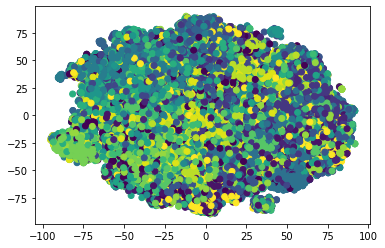

In [40]:
plt.scatter(style_embedded[:, 0], style_embedded[:, 1], c = sample_flickr.label.tolist())
plt.show()

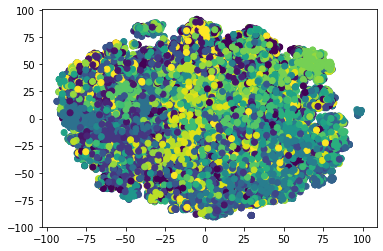

In [41]:
plt.scatter(clip_embedded[:, 0], clip_embedded[:, 1], c = sample_flickr.label.tolist())
plt.show()

In [61]:
# fig, ax = plt.subplots()
# for i, col in enumerate(colors):
#     ix = sample_flickr[sample_flickr['label']==i].index
#     ax.scatter(style_embedded[ix, 0], style_embedded[ix, 1], c = col, label=i)
# plt.legend()
# plt.show()

## Cosine similarity plots for each style label

Detailed
num of images: 2702
cosine mean 0.5237603


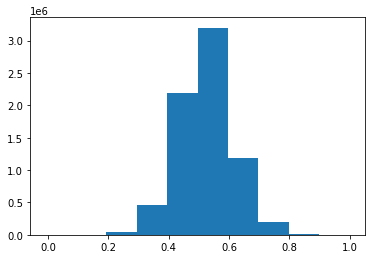

Melancholy
num of images: 2875
cosine mean 0.55495214


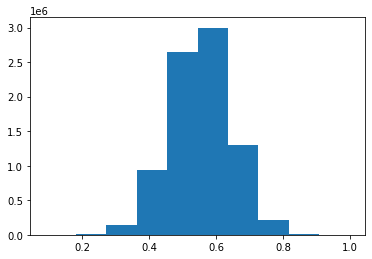

Pastel
num of images: 2707
cosine mean 0.54903626


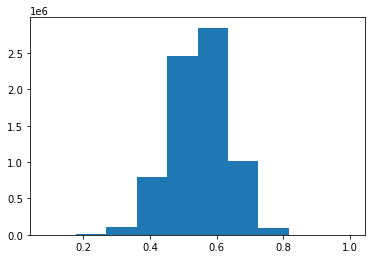

Noir
num of images: 3117
cosine mean 0.5818155


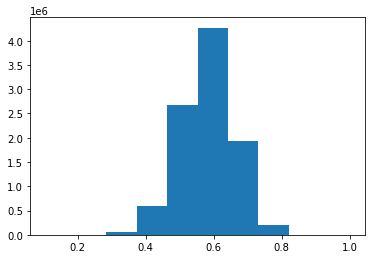

HDR
num of images: 3179
cosine mean 0.5351019


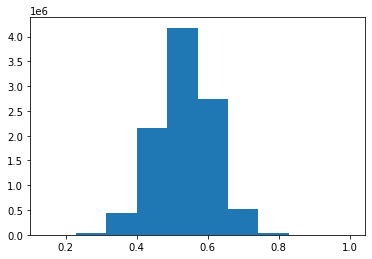

Vintage
num of images: 3123
cosine mean 0.5365551


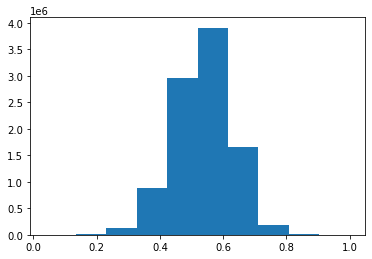

Long Exposure
num of images: 2810
cosine mean 0.5650902


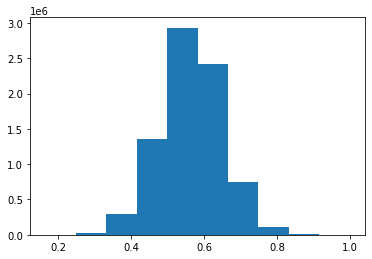

Horror
num of images: 3413
cosine mean 0.55959475


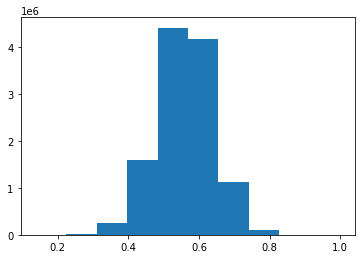

Sunny
num of images: 3193
cosine mean 0.62205374


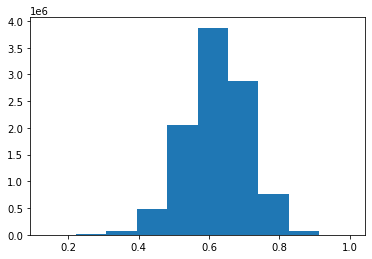

Bright
num of images: 3074
cosine mean 0.5175862


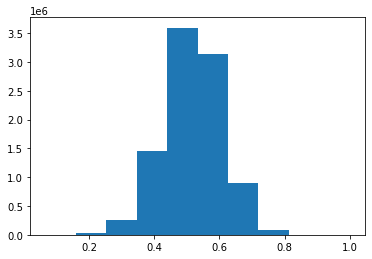

Hazy
num of images: 3030
cosine mean 0.5791818


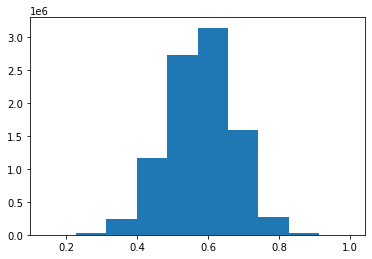

Bokeh
num of images: 3202
cosine mean 0.5670947


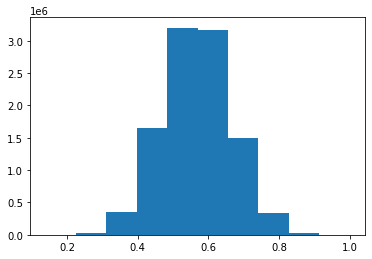

Serene
num of images: 3207
cosine mean 0.5586912


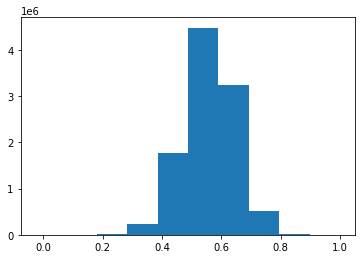

Texture
num of images: 3244
cosine mean 0.55661994


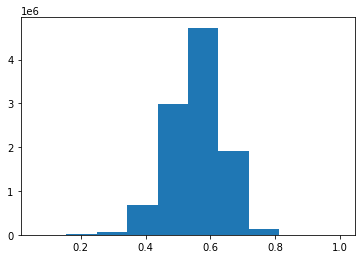

Ethereal
num of images: 3139
cosine mean 0.58883625


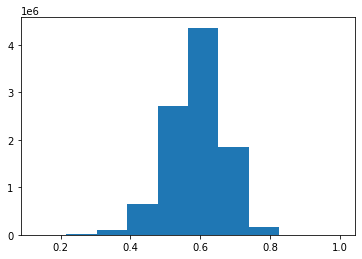

Macro
num of images: 2932
cosine mean 0.61182755


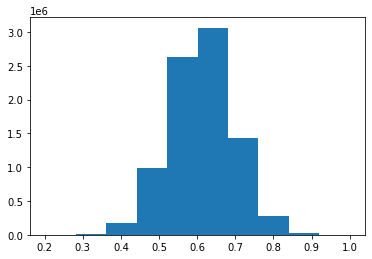

Depth of Field
num of images: 3027
cosine mean 0.5384739


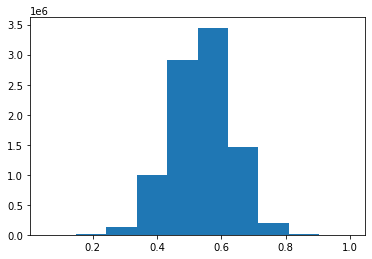

Geometric Composition
num of images: 2879
cosine mean 0.5643442


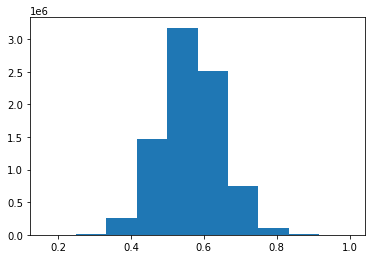

Minimal
num of images: 2809
cosine mean 0.6023804


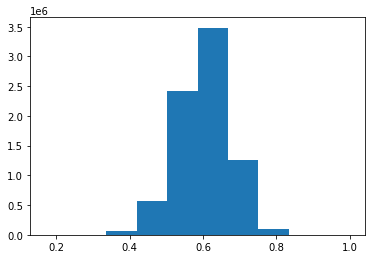

Romantic
num of images: 2836
cosine mean 0.5307739


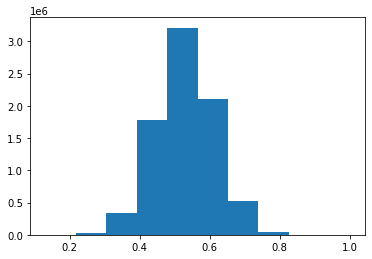

In [116]:
style_cos_sims = []
for style in flickr_data.label.unique():
    print(labels_to_styles[style])
    print('num of images:',flickr_data[flickr_data['label']==style].shape[0])
    cos_sim_style = cosine_similarity(np.stack(flickr_data[flickr_data['label']==style]['style_emb'].values))
    print('cosine mean',cos_sim_style.mean())
    style_cos_sims.append(cos_sim_style.mean())
    plt.hist(cos_sim_style.flatten())
    plt.show()

Detailed
num of images: 2702
cosine mean 0.5396734


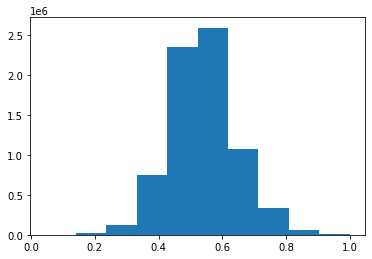

Melancholy
num of images: 2875
cosine mean 0.594803


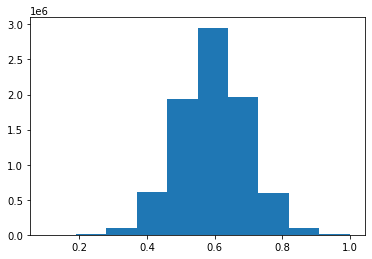

Pastel
num of images: 2707
cosine mean 0.6008213


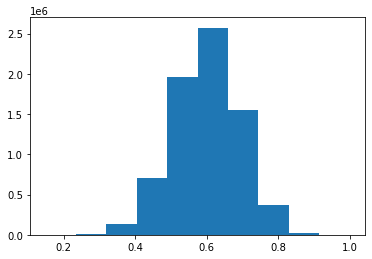

Noir
num of images: 3117
cosine mean 0.6470543


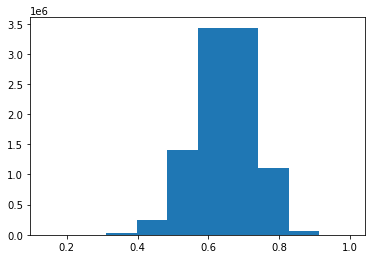

HDR
num of images: 3179
cosine mean 0.54657215


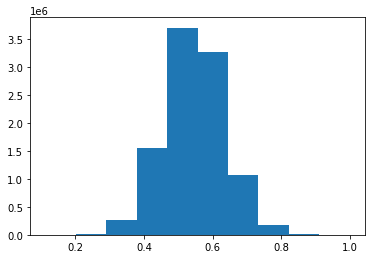

Vintage
num of images: 3123
cosine mean 0.57243073


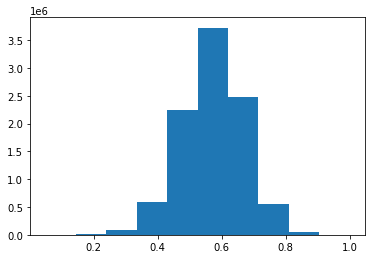

Long Exposure
num of images: 2810
cosine mean 0.5997381


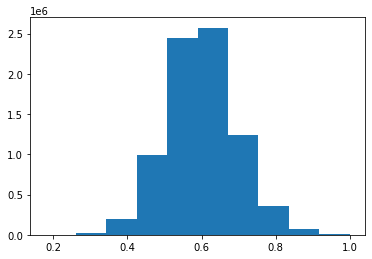

Horror
num of images: 3413
cosine mean 0.6167747


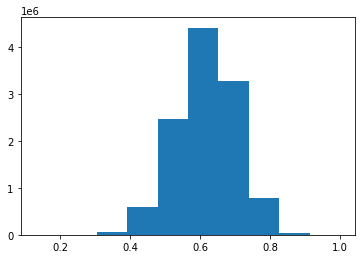

Sunny
num of images: 3193
cosine mean 0.6781119


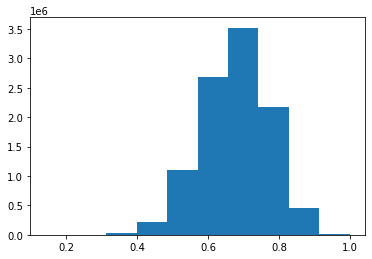

Bright
num of images: 3074
cosine mean 0.549638


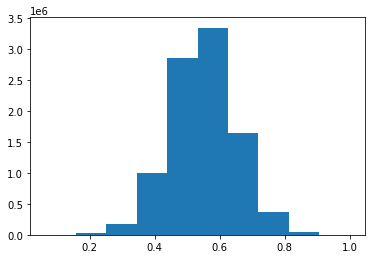

Hazy
num of images: 3030
cosine mean 0.6303709


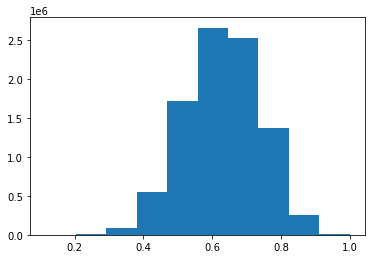

Bokeh
num of images: 3202
cosine mean 0.6035501


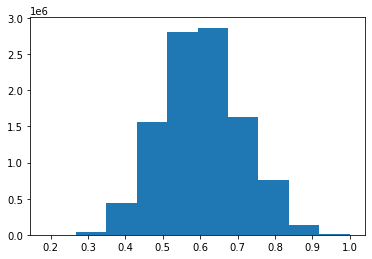

Serene
num of images: 3207
cosine mean 0.58330655


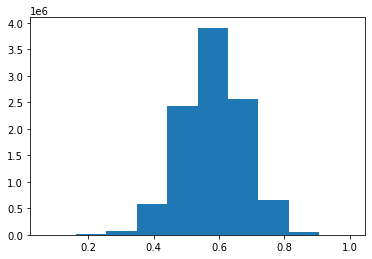

Texture
num of images: 3244
cosine mean 0.60294366


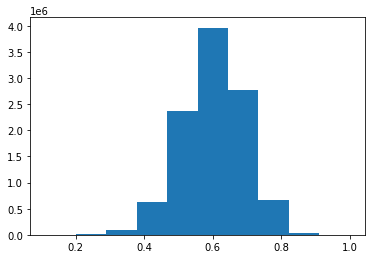

Ethereal
num of images: 3139
cosine mean 0.654891


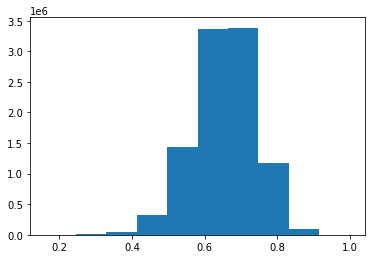

Macro
num of images: 2932
cosine mean 0.663757


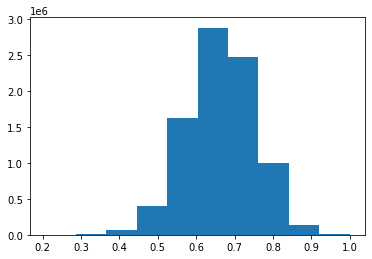

Depth of Field
num of images: 3027
cosine mean 0.5676173


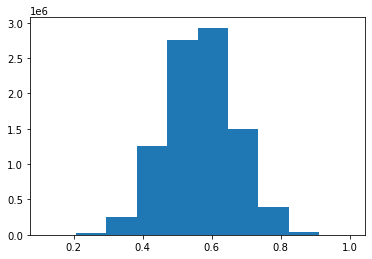

Geometric Composition
num of images: 2879
cosine mean 0.6168836


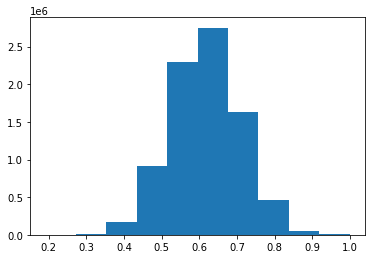

Minimal
num of images: 2809
cosine mean 0.6607422


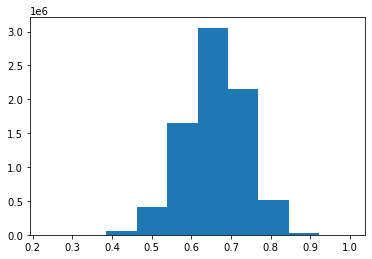

Romantic
num of images: 2836
cosine mean 0.56146765


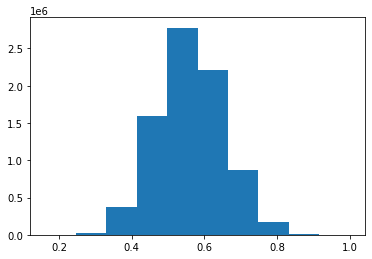

In [117]:
clip_cos_sims = []
for style in flickr_data.label.unique():
    print(labels_to_styles[style])
    print('num of images:',flickr_data[flickr_data['label']==style].shape[0])
    cos_sim_clip = cosine_similarity(np.stack(flickr_data[flickr_data['label']==style]['clip_emb'].values))
    print('cosine mean',cos_sim_clip.mean())
    clip_cos_sims.append(cos_sim_clip.mean())
    plt.hist(cos_sim_clip.flatten())
    plt.show()

In [118]:
style_cos_sims

[0.5237603,
 0.55495214,
 0.54903626,
 0.5818155,
 0.5351019,
 0.5365551,
 0.5650902,
 0.55959475,
 0.62205374,
 0.5175862,
 0.5791818,
 0.5670947,
 0.5586912,
 0.55661994,
 0.58883625,
 0.61182755,
 0.5384739,
 0.5643442,
 0.6023804,
 0.5307739]

In [119]:
clip_cos_sims

[0.5396734,
 0.594803,
 0.6008213,
 0.6470543,
 0.54657215,
 0.57243073,
 0.5997381,
 0.6167747,
 0.6781119,
 0.549638,
 0.6303709,
 0.6035501,
 0.58330655,
 0.60294366,
 0.654891,
 0.663757,
 0.5676173,
 0.6168836,
 0.6607422,
 0.56146765]

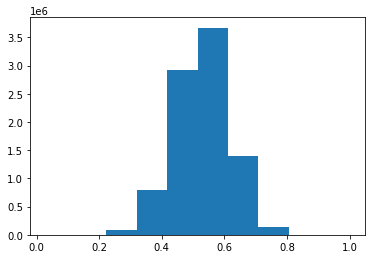

In [111]:
plt.hist(cosine_similarity(np.stack(flickr_data.sample(n=3000)['style_emb'].values)).flatten())
plt.show()

## Testing single images

In [91]:
flickr_data = flickr_data.reset_index(drop=True)

In [100]:
styles_sim_mtx = cosine_similarity(np.stack(flickr_data['style_emb'].values))
flickr_data['most_sim_style'] = flickr_data.apply(lambda row: flickr_data.loc[find_most_sim_emb(row.name, styles_sim_mtx), 'image_url']
                                                  , axis=1)

In [101]:
clips_sim_mtx = cosine_similarity(np.stack(flickr_data['clip_emb'].values))
flickr_data['most_sim_clip'] = flickr_data.apply(lambda row: flickr_data.loc[find_most_sim_emb(row.name, clips_sim_mtx), 'image_url']
                                                  , axis=1)

In [113]:
style = 'Ethereal'
flickr_data[(flickr_data['style']==style) & (flickr_data['most_sim_style'] != flickr_data['most_sim_clip'])][
    ['image_url', 'most_sim_style', 'most_sim_clip']].reset_index().loc[2]

index             42878                                                        
image_url         http://farm4.staticflickr.com/3733/13256491444_27b1134cd3.jpg
most_sim_style    http://farm3.staticflickr.com/2883/13198974043_d22f8c20aa.jpg
most_sim_clip     http://farm3.staticflickr.com/2862/9789606224_5b0e4812a2.jpg 
Name: 2, dtype: object